In [1]:
%matplotlib inline

### Radar Plots
We make the radar plots for Watford's midfield trio and look for better players in other top 5 leagues

In [2]:
import pandas as pd
import numpy as np
import json
# plotting
import matplotlib.pyplot as plt
# statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf
#opening data
import os
import pathlib
import warnings 
#used for plots
from scipy import stats
from mplsoccer import PyPizza, FontManager

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

### Opening data France
For this task we will use Wyscout data. We open it, save in the dataframe
*train*. To avoid potential errors, we keep
only the data for which the beginning and end of an action was registered. 

In [3]:
train = pd.DataFrame()
with open('data/Wyscout/events_France.json') as f:
    data = json.load(f)
train = pd.concat([train, pd.DataFrame(data)])
#potential data collection error handling
train = train.loc[train.apply (lambda x: len(x.positions) == 2, axis = 1)]

### Calculating air and ground duels won

In [4]:
def wonDuels(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    duels_won: dataframe
        dataframe with number of won air and ground duels for a player 

    """
    #find air duels
    air_duels = df.loc[df["subEventName"] == "Air duel"]
    #703 is the id of a won duel
    won_air_duels = air_duels.loc[air_duels.apply (lambda x:{'id':703} in x.tags, axis = 1)]
    
    #group and sum air duels
    wad_player =  won_air_duels.groupby(["playerId"]).eventId.count().reset_index()
    wad_player.rename(columns = {'eventId':'air_duels_won'}, inplace=True)
    
    #find ground duels won
    ground_duels = df.loc[df["subEventName"].isin(["Ground defending duel"])]
    won_ground_duels = ground_duels.loc[ground_duels.apply (lambda x:{'id':703} in x.tags, axis = 1)]
    
    wgd_player =  won_ground_duels.groupby(["playerId"]).eventId.count().reset_index()
    wgd_player.rename(columns = {'eventId':'ground_duels_won'}, inplace=True)
    
    #find anticipation
    ground_duels = df.loc[df["subEventName"].isin(["Ground defending duel"])]
    won_ground_duels = ground_duels.loc[ground_duels.apply (lambda x:{'id':20} in x.tags, axis = 1)]
    
    #outer join
    duels_won = wgd_player.merge(wad_player, how = "outer", on = ["playerId"])
    return duels_won

duels = wonDuels(train)
#investigate structure
duels.head(3)

,playerId,ground_duels_won,air_duels_won
0,0,1281.0,829.0
1,102,55.0,150.0
2,118,15.0,9.0


### Interceptions

In [5]:
def interception(df):
    #find interceptions
    intercept = df.loc[df["eventId"] == 8]
    interception = intercept.loc[intercept.apply (lambda x:{'id':1401} in x.tags, axis = 1)]
    
    intercept_player =  interception.groupby(["playerId"]).eventId.count().reset_index()
    intercept_player.rename(columns = {'eventId':'interceptions'}, inplace=True)
    
    return intercept_player

interceptions = interception(train)
#investigate structure
interceptions.head(3)

,playerId,interceptions
0,102,88
1,118,16
2,123,6


### Passes

In [6]:
def passing(df):
    #find passes
    passes = df.loc[df["eventId"] == 8]
    good_pass = passes.loc[passes.apply (lambda x:{'id':1801} in x.tags, axis = 1)]
    bad_pass = passes.loc[passes.apply (lambda x:{'id':1802} in x.tags, axis = 1)]
    
    good_pass_num =  good_pass.groupby(["playerId"]).eventId.count().reset_index()
    bad_pass_num =  bad_pass.groupby(["playerId"]).eventId.count().reset_index()
    
    good_pass_num.rename(columns = {'eventId':'successful_passes'}, inplace=True)
    bad_pass_num.rename(columns = {'eventId':'unsuccessful_passes'}, inplace=True)
    
    #outer join
    passes = good_pass_num.merge(bad_pass_num, how = "outer", on = ["playerId"])
    passes["pass_percent"] = round((passes['successful_passes']/(passes['successful_passes']+passes['unsuccessful_passes']))*100,2)
    
    return passes

# selecting first and last column
passing = passing(train).iloc[:, [0, -1]]
#investigate structure
passing.head(3)

,playerId,pass_percent
0,0,66.67
1,66,85.71
2,102,90.00


### Minutes Played
All data on our plot will be per 90 minutes played. Therefore, we need an information on the number of minutes played
throughout the season. To do so, we will use a prepared file that bases on the idea developed by students
taking part in course in 2021. Files with miutes per game for players in top 5 leagues can be found
[here](https://github.com/soccermatics/Soccermatics/tree/main/course/lessons/minutes_played). After downloading data and saving
it in out directory, we open it and store in a dataframe. Then we calculate the sum of miutes played in a season for each player.

In [7]:
with open('data/minutes_played_per_game_France.json') as f:
    minutes_per_game = json.load(f)
minutes_per_game = pd.DataFrame(minutes_per_game)
minutes = minutes_per_game.groupby(["playerId"]).minutesPlayed.sum().reset_index()

### Summary

In [8]:
players = train["playerId"].unique()
summary = pd.DataFrame(players, columns = ["playerId"])
summary = summary.merge(duels, how = "left", on = ["playerId"]).merge(interceptions, how = "left", on = ["playerId"]).merge(passing, how = "left", on = ["playerId"])

summary = minutes.merge(summary, how = "left", on = ["playerId"])
summary = summary.fillna(0)
summary = summary.loc[summary["minutesPlayed"] > 400]

### Filter for midfielders

In [9]:
with open('data/Wyscout/players.json') as f:
    players = json.load(f)
player_df = pd.DataFrame(players)
midfielders = player_df.loc[player_df.apply(lambda x: x.role["name"] == "Midfielder", axis = 1)]
midfielders.rename(columns = {'wyId':'playerId'}, inplace=True)
to_merge = midfielders[['playerId', 'shortName']]
summary = summary.merge(to_merge, how = "inner", on = ["playerId"])

In [10]:
# Rename correctly to avoid future problems
summary.loc[102, "shortName"] = 'A. Toure'
summary.loc[128, "shortName"] = 'Otavio'
summary.loc[143, "shortName"] = 'I. Sangare'
summary.loc[127, "shortName"] = 'T. Ndombele'

In [12]:
summary.to_csv("french_summary_mid.csv", index=False)

### Calculating statistics per 90

In [13]:
summary_per_90 = pd.DataFrame()
summary_per_90["shortName"] = summary["shortName"]
for column in summary.columns[2:-2]:
    summary_per_90[column + "_per90"] = summary.apply(lambda x: x[column]*90/x["minutesPlayed"], axis = 1)

In [14]:
# Merging with pass completion
summary_per_90=summary_per_90.merge(summary[['shortName', 'pass_percent']], on='shortName', how='inner')

In [15]:
# SOrting by who had the most interceptions per 90
summary_per_90.sort_values(by=summary_per_90.columns[3], ascending=False)

,shortName,ground_duels_won_per90,air_duels_won_per90,interceptions_per90,pass_percent
23,J. Pla\u0161il,1.988950,0.580110,3.563536,88.99
67,J. Grimm,2.068966,2.586207,3.310345,81.68
128,Otavio,2.300131,0.825688,3.302752,89.07
139,A. Zambo Anguissa,2.985782,2.381517,3.270142,90.70
147,D. Avounou,1.353383,0.812030,3.112782,73.62
...,...,...,...,...,...
140,J. Reine-Adelaide,2.195122,1.796009,0.199557,85.82
59,N. Fekir,1.048544,0.733981,0.174757,85.78
56,Y. Salibur,0.631780,0.574346,0.172304,81.68
20,P. Ntep,1.519700,1.688555,0.168856,69.06


In [ ]:
summary_per_90.to_csv("french_midfielders.csv", index=False)

In [16]:
#player to investigate - T. Cleverley
#only his statistics
cleverly = summary_per_90.loc[summary_per_90["shortName"] == "A. Zambo Anguissa"]
#columns similar together
cleverly = cleverly[['ground_duels_won_per90', "air_duels_won_per90", "interceptions_per90", "pass_percent"]]
#take only necessary columns - exclude playerId
per_90_columns = cleverly.columns[:]
#values to mark on the plot
values = [round(cleverly[column].iloc[0],2) for column in per_90_columns]
#percentiles
percentiles = [int(stats.percentileofscore(summary_per_90[column], cleverly[column].iloc[0])) for column in per_90_columns]

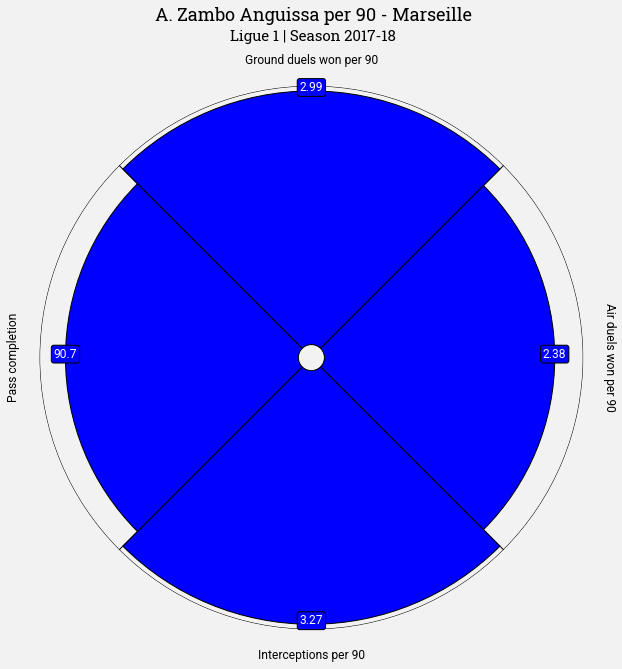

In [17]:
#list of names on plots
names = ["Ground duels won per 90", "Air duels won per 90", "Interceptions per 90", "Pass completion"]
slice_colors = ["blue"] * 4
text_colors = ["white"]*4
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                         "RobotoSlab%5Bwght%5D.ttf?raw=true"))
#PIZZA PLOT
baker = PyPizza(
    params=names,   
    min_range = None,
    max_range = None,               # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)
#making pizza for our data
fig, ax = baker.make_pizza(
    percentiles,              # list of values
    figsize=(10, 10),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,
    value_bck_colors=slice_colors, # where the parameters will be added
    kwargs_slices=dict(
        facecolor="cornflowerblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                    # values to be used when adding parameter-values
)

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values[i]))
# add title
fig.text(
    0.515, 0.97, "A. Zambo Anguissa per 90 - Marseille", size=18,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Ligue 1 | Season 2017-18",
    size=15,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

plt.savefig("anguissa",bbox_figure="tight",dpi=300)
plt.show()

## Calculating possession
As the next step we would like to adjust our plot by the player's team ball possesion while they 
were on the pitch. To do it, for each row of our dataframe with minutes per player per each game 
we take all the events that were made in this game while the player was on the pitch.
We will also use duels, but
don't include lost air duels and lost ground defending duels. Why? Possesion is calculated as number of touches by team divided
by the number all touches. If a player lost ground defending duel, that means that he could have been dribbled by, so he did not
touch the ball. If they lost the air duel, they lost a header. Therefore, we claim that those were mostly events where player may have not
touched the ball (or if he did the team did not take control over it). We sum 
both team passes and these duels and all passes and these duels in this period. We store these values in a 
dictionary. Then, summing them for each player separately and calculating their ratio, we get 
the possesion of the ball by player's team while he was on the pitch. As the last step we merge it with our summary dataframe.

In [18]:
possesion_dict = {}
#for every row in the dataframe
for i, row in minutes_per_game.iterrows():
    #take player id, team id and match id, minute in and minute out
    player_id, team_id, match_id = row["playerId"], row["teamId"], row["matchId"]
    #create a key in dictionary if player encounterd first time
    if not str(player_id) in possesion_dict.keys():
        possesion_dict[str(player_id)] = {'team_passes': 0, 'all_passes' : 0}
    min_in = row["player_in_min"]*60
    min_out = row["player_out_min"]*60
    
    #get the dataframe of events from the game
    match_df = train.loc[train["matchId"] == match_id].copy()
    #add to 2H the highest value of 1H
    match_df.loc[match_df["matchPeriod"] == "2H", 'eventSec'] = match_df.loc[match_df["matchPeriod"] == "2H", 'eventSec'] + match_df.loc[match_df["matchPeriod"] == "1H"]["eventSec"].iloc[-1]
    #take all events from this game and this period
    player_in_match_df = match_df.loc[match_df["eventSec"] > min_in].loc[match_df["eventSec"] <= min_out]
    #take all passes and won duels as described
    all_passes = player_in_match_df.loc[player_in_match_df["eventName"].isin(["Pass", "Duel"])]
    #adjusting for no passes in this period (Tuanzebe)
    if len(all_passes) > 0:
        #removing lost air duels
        no_contact = all_passes.loc[all_passes["subEventName"].isin(["Air duel", "Ground defending duel","Ground loose ball duel"])].loc[all_passes.apply(lambda x:{'id':701} in x.tags, axis = 1)]
        all_passes = all_passes.drop(no_contact.index)
    #take team passes 
    team_passes = all_passes.loc[all_passes["teamId"] == team_id]
    #append it {player id: {team passes: sum, all passes : sum}}
    possesion_dict[str(player_id)]["team_passes"] += len(team_passes)
    possesion_dict[str(player_id)]["all_passes"] += len(all_passes)

#calculate possesion for each player
percentage_dict = {key: value["team_passes"]/value["all_passes"] if value["all_passes"] > 0 else 0 for key, value in possesion_dict.items()}
#create a dataframe
percentage_df = pd.DataFrame(percentage_dict.items(), columns = ["playerId", "possesion"])
percentage_df["playerId"] = percentage_df["playerId"].astype(int)
#merge it
summary = summary.merge(percentage_df, how = "left", on = ["playerId"])

## Adjusting data for possession
Since we would like to adjust our values by possession, we divide the total statistics by the
possesion while player was on the pitch during the entire season. To normalize the values per 
90 minutes player we repeat the multiplication by 90 and division by minutes played.

In [19]:
#create a new dataframe only for it
summary_adjusted = pd.DataFrame()
summary_adjusted["shortName"] = summary["shortName"]
#calculate value adjusted
for column in summary.columns[2:5]:
    summary_adjusted[column + "_adjusted_per90"] = summary.apply(lambda x: (x[column]/x["possesion"])*90/x["minutesPlayed"], axis = 1)

In [20]:
# Merging with pass completion
summary_adjusted=summary_adjusted.merge(summary_per_90[['shortName', 'pass_percent']], on='shortName', how='inner')

In [21]:
summary_adjusted

,shortName,ground_duels_won_adjusted_per90,air_duels_won_adjusted_per90,interceptions_adjusted_per90,pass_percent
0,\u00c1. di Mar\u00eda,0.781328,0.000000,0.716218,75.11
1,L. Diarra,1.836145,2.295181,2.065663,92.96
2,J. Toulalan,3.594693,3.235224,3.504826,87.69
3,M. Abeid,3.090385,2.472308,3.708462,87.57
4,S. Sess\u00e8gnon,0.790094,1.777711,0.987617,83.91
...,...,...,...,...,...
147,D. Avounou,3.063815,1.838289,7.046775,73.62
148,B. Srarfi,1.856314,1.181291,1.012535,82.96
149,Y. Bissouma,5.468275,2.888900,3.507950,86.43
150,J. Deminguet,3.601920,3.241728,3.962113,72.28


In [22]:
summary_adjusted.to_csv("french_midfielders.csv", index=False)

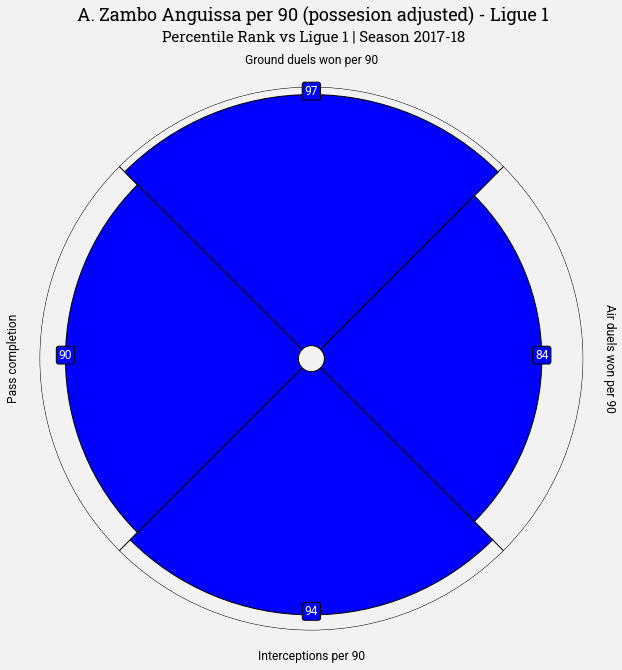

In [21]:
cleverly_adjusted = summary_adjusted.loc[summary_adjusted["shortName"] == "A. Zambo Anguissa"]
cleverly_adjusted = cleverly_adjusted[['ground_duels_won_adjusted_per90', "air_duels_won_adjusted_per90", "interceptions_adjusted_per90", "pass_percent"]]
#take only necessary columns
adjusted_columns = cleverly_adjusted.columns[:]
#values
values = [cleverly_adjusted[column].iloc[0] for column in adjusted_columns]
#percentiles
percentiles = [int(stats.percentileofscore(summary_adjusted[column], cleverly_adjusted[column].iloc[0])) for column in adjusted_columns]
names = names = ["Ground duels won per 90", "Air duels won per 90", "Interceptions per 90", "Pass completion"]


font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_italic = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto-Italic%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                         "RobotoSlab%5Bwght%5D.ttf?raw=true"))

baker = PyPizza(
    params=names,                  # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)

fig, ax = baker.make_pizza(
    percentiles,              # list of values
    figsize=(10, 10),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,
    value_bck_colors=slice_colors,
    # where the parameters will be added
    kwargs_slices=dict(
        facecolor="cornflowerblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                    # values to be used when adding parameter-values
)

# add title
fig.text(
    0.515, 0.97, "A. Zambo Anguissa per 90 (possesion adjusted) - Ligue 1", size=18,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Percentile Rank vs Ligue 1 | Season 2017-18",
    size=15,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

plt.savefig("anguissa_padj",bbox_figure="tight",dpi=300)
plt.show()